<a href="https://colab.research.google.com/github/moarshy/PyTorch_fastai_Projects/blob/main/fastai_imgc_plantpathology_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The idea of this notebook is to use fastai with timm's efficientnet model. 

We will use Plant Pathology dataset from Kaggle and see what scoring we can achieve

Tecniques used in this image classification
* transfer learning
* efficientnet architecture from timm
* stratified kfold crossvalidation
* MixUp
* label smoothing
* TTA


In this notebook, our results were private score: 0.96454 and public score: 0.96877. There is still room for further improvement

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip uninstall fastai -q -y
!pip install fastai -q

In [ ]:
!pip install timm -q

In [ ]:
! pip install iterative-stratification > /dev/null -q

In [ ]:
import fastai
from fastai.vision.all import *
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold
from sklearn.metrics import roc_auc_score

import pandas as pd
from tqdm.notebook import tqdm

In [ ]:
from timm import create_model
import timm
from fastai.vision.learner import _update_first_layer
from fastai.vision.learner import _add_norm
import torch.nn as nn

# Experiment set-up

* transfer learning --> densnet201
* img_size 600
* batch size 16
* mixup
* stratified kfold
* oversampling
* label smoothing
* tta

In [ ]:
PATH = Path('/content/drive/MyDrive/colab_notebooks/fastai/Plant Pathology')
DATA_DIR = Path('/content/drive/MyDrive/colab_notebooks/fastai/Plant Pathology/data')
IMG_DIR = PATH/'data/images'
TRAIN_CSV = 'train.csv'
TEST_CSV = 'test.csv'
SS_CSV = 'sample_submission.csv'

In [ ]:
SEED = 42
set_seed(42)
N_FOLDS = 5
IMG_SIZE = 128
BS = 64

In [ ]:
train_df = pd.read_csv(DATA_DIR/TRAIN_CSV)

In [ ]:
train_df.head()

,image_id,healthy,multiple_diseases,rust,scab
0,Train_0,0,0,0,1
1,Train_1,0,1,0,0
2,Train_2,1,0,0,0
3,Train_3,0,0,1,0
4,Train_4,1,0,0,0


In [ ]:
LABELS = ['healthy', 'multiple_diseases', 'rust', 'scab']


In [ ]:
train_df['label'] = train_df[LABELS].idxmax(1)

# Oversampling and dataloader

In [ ]:
#create folds
train_df['fold'] = -1

strat_kfold = MultilabelStratifiedKFold(n_splits=N_FOLDS, random_state=SEED, shuffle=True)
for i, (_, test_index) in enumerate(strat_kfold.split(train_df.image_id.values, train_df.iloc[:,1:].values)):
    train_df.iloc[test_index, -1] = i
    
train_df['fold'] = train_df['fold'].astype('int')

In [ ]:
def get_data(fold):
    
    train_df_no_val = train_df[train_df['fold'] != {fold}]     #training set
    train_df_just_val = train_df[train_df['fold'] == {fold}]   #validation set

    train_df_bal = pd.concat(
                   [train_df_no_val[train_df_no_val['label'] != "multiple_diseases"], train_df_just_val] +
                   [train_df_no_val[train_df_no_val['label'] == 'multiple_diseases']] * 6
                   ).sample(frac=1.0, random_state=SEED).reset_index(drop=True)

    datablock = DataBlock(
                blocks=(ImageBlock, CategoryBlock(vocab=LABELS)),
                getters=[
                ColReader('image_id', pref=IMG_DIR, suff='.jpg'),
                ColReader('label')
                ],
                splitter=IndexSplitter(train_df_bal.loc[train_df_bal.fold==fold].index),
                item_tfms=Resize(IMG_SIZE),
                batch_tfms=[*aug_transforms(size=IMG_SIZE, max_rotate=30., min_scale=0.75, flip_vert=True, do_flip=True), 
                        Normalize.from_stats(*imagenet_stats)]
                )
    return datablock.dataloaders(source=train_df_bal, bs=BS)

In [ ]:
def comp_metric(preds, targs, labels=range(len(LABELS))):
    # One-hot encode targets
    targs = np.eye(4)[targs]
    return np.mean([roc_auc_score(targs[:,i], preds[:,i]) for i in labels])

def healthy_roc_auc(*args):
    return comp_metric(*args, labels=[0])

def multiple_diseases_roc_auc(*args):
    return comp_metric(*args, labels=[1])

def rust_roc_auc(*args):
    return comp_metric(*args, labels=[2])

def scab_roc_auc(*args):
    return comp_metric(*args, labels=[3])

# timm Model



In [ ]:
class Model(nn.Module):
    def __init__(self, model_arch, n_class, pretrained=False):
        super().__init__()
        self.model = timm.create_model(model_arch, pretrained=pretrained)
        n_features = self.model.classifier.in_features
        self.model.classifier = nn.Linear(n_features, n_class)
        
    def forward(self, x):
        x = self.model(x)
        return x

In [ ]:
model = Model('tf_efficientnet_b3_ns', len(LABELS), pretrained=True)

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/tf_efficientnet_b3_ns-9d44bf68.pth" to /root/.cache/torch/hub/checkpoints/tf_efficientnet_b3_ns-9d44bf68.pth


In [ ]:
dls = get_data(0)

In [ ]:
opt_func = partial(Adam, lr=1e-3, wd=0.005, eps=1e-8)
learn = Learner(dls, model, loss_func=LabelSmoothingCrossEntropy(),
                opt_func=opt_func,
                metrics=[accuracy, AccumMetric(comp_metric, flatten=False)],
                cbs=MixUp()).to_fp16()

SuggestedLRs(lr_min=0.0019054606556892395, lr_steep=0.001737800776027143)

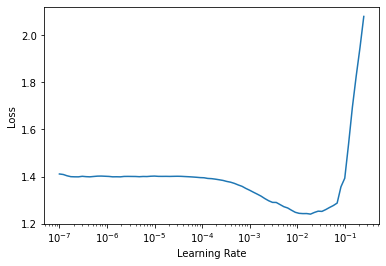

In [ ]:
learn.lr_find()

In [ ]:
learn.fine_tune(5, base_lr=0.0017378, freeze_epochs=2)

epoch,train_loss,valid_loss,accuracy,comp_metric,time
0,1.251482,0.834706,0.756545,0.895529,02:04
1,1.054975,0.789331,0.821990,0.875768,01:26


epoch,train_loss,valid_loss,accuracy,comp_metric,time
0,0.834447,0.643697,0.853403,0.931786,01:26
1,0.809841,0.645811,0.874346,0.921489,01:25
2,0.796481,0.610828,0.887435,0.937501,01:25
3,0.781504,0.648869,0.884817,0.915322,01:25
4,0.759213,0.616056,0.890052,0.931546,01:26


In [ ]:
learn.unfreeze()

# Trainging with efficientnet

In [ ]:
IMG_SIZE = 600
BS = 16

In [ ]:
def get_learner(fold_num, model):

    data = get_data(fold_num)
    opt_func = partial(Adam, lr=1e-3, wd=0.005, eps=1e-8)
    learn = Learner(
        data, model, loss_func=LabelSmoothingCrossEntropy(),
        opt_func = opt_func,
        metrics=[accuracy, AccumMetric(comp_metric, flatten=False)],
        cbs=MixUp()).to_fp16()

    return learn

Fold 0 results


epoch,train_loss,valid_loss,accuracy,comp_metric,time
0,0.643899,0.423214,0.976440,0.987116,02:07
1,0.653210,0.388196,0.986911,0.992105,02:09
2,0.626883,0.386649,0.986911,0.997562,02:09


epoch,train_loss,valid_loss,accuracy,comp_metric,time
0,0.642750,0.416256,0.984293,0.995817,02:11
1,0.666391,0.464986,0.939791,0.990527,02:12
2,0.652677,0.425493,0.973822,0.987699,02:12
3,0.636264,0.420738,0.973822,0.988795,02:12
4,0.615271,0.411800,0.984293,0.994817,02:12
5,0.602413,0.404939,0.984293,0.994872,02:12


Fold 1 results


epoch,train_loss,valid_loss,accuracy,comp_metric,time
0,0.665327,0.397150,0.981675,0.999438,02:11
1,0.655469,0.383951,0.989529,0.999787,02:16
2,0.618138,0.376811,0.989529,0.999925,02:15


epoch,train_loss,valid_loss,accuracy,comp_metric,time
0,0.618753,0.381934,0.992147,0.999975,02:14
1,0.639478,0.430898,0.968586,0.995581,02:13
2,0.639131,0.413696,0.971204,0.998638,02:12
3,0.630620,0.383500,0.989529,0.999541,02:12
4,0.632871,0.388269,0.981675,0.999150,02:11
5,0.608948,0.382307,0.984293,0.999383,02:10


Fold 2 results


epoch,train_loss,valid_loss,accuracy,comp_metric,time
0,0.671980,0.401519,0.981675,0.999425,02:10
1,0.634348,0.371006,0.994764,0.999317,02:10
2,0.622128,0.368189,0.994764,0.999574,02:09


epoch,train_loss,valid_loss,accuracy,comp_metric,time
0,0.610940,0.378448,0.992147,0.999603,02:09
1,0.648033,0.415220,0.976440,0.997154,02:08
2,0.635492,0.381836,0.992147,0.999356,02:08
3,0.625655,0.386691,0.984293,0.999291,02:08
4,0.607153,0.378458,0.989529,0.998864,02:07
5,0.597830,0.374053,0.992147,0.999425,02:08


Fold 3 results


epoch,train_loss,valid_loss,accuracy,comp_metric,time
0,0.635362,0.393685,0.984334,0.999153,02:09
1,0.634572,0.382443,0.989556,0.999780,02:08
2,0.612179,0.365901,0.997389,0.999924,02:08


epoch,train_loss,valid_loss,accuracy,comp_metric,time
0,0.599160,0.368581,0.989556,0.999959,02:08
1,0.658362,0.408666,0.976501,0.996489,02:07
2,0.626428,0.373978,0.986945,0.999983,02:07
3,0.642327,0.381586,0.986945,0.999839,02:10
4,0.615132,0.368494,0.992167,0.999924,02:09
5,0.609591,0.365360,0.994778,0.999924,02:08


Fold 4 results


epoch,train_loss,valid_loss,accuracy,comp_metric,time
0,0.646600,0.371056,0.994778,0.999952,02:08
1,0.642292,0.374897,0.997389,0.997265,02:08
2,0.619978,0.366672,0.997389,0.997353,02:09


epoch,train_loss,valid_loss,accuracy,comp_metric,time
0,0.607602,0.372398,0.997389,0.997161,02:08
1,0.633818,0.420553,0.976501,0.997408,02:08
2,0.644183,0.384016,0.992167,0.999168,02:08
3,0.622727,0.398131,0.992167,0.997105,02:07
4,0.607728,0.389593,0.997389,0.997161,02:08
5,0.594803,0.385305,0.997389,0.997161,02:07


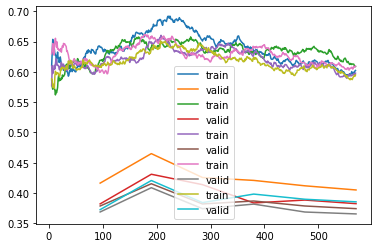

In [ ]:
for i in range(N_FOLDS):
    print(f'Fold {i} results')
    savemodel = SaveModelCallback(monitor='valid_loss', every_epoch=True, fname=f'{DATA_DIR}/model/model_efficientnet_best_fold_{i}')
    learn = get_learner(fold_num=i, model=model)

    learn.fit_one_cycle(3)
    learn.unfreeze()
    learn.fit_one_cycle(6, slice(1e-6, 1e-3), cbs=savemodel)
    
    learn.recorder.plot_loss()
    
    learn.save(f'{DATA_DIR}/model/model_efficientnet_fold_{i}')

In [ ]:
# Prediction - no tta

In [ ]:
dls = get_data(0)
test_df = pd.read_csv(DATA_DIR/TEST_CSV)
test_dl = dls.test_dl(test_df)

In [ ]:
preds = []
for i in range(N_FOLDS):
  learn = get_learner(i, model=model)
  learn.load(f'{DATA_DIR}/model/model_efficientnet_fold_{i}')

  test_preds, _ = learn.get_preds(dl=test_dl)
  preds.append(test_preds)

In [ ]:
test_preds= np.mean(np.stack(preds), axis=0)

In [ ]:
sub_df = pd.concat([test_df, pd.DataFrame(test_preds, columns=LABELS)], axis=1)
sub_df = sub_df[['image_id', 'healthy', 'multiple_diseases', 'rust', 'scab']]
sub_df.to_csv(f'{DATA_DIR}/submission_efficient_notta.csv', index=False)

In [ ]:
#preds with tta
preds = []
for i in range(N_FOLDS):
  learn = get_learner(i, model=model)
  learn.load(f'{DATA_DIR}/model/model_efficientnet_fold_{i}')

  test_preds, _ = learn.tta(dl=test_dl)
  preds.append(test_preds)

In [ ]:
test_preds= np.mean(np.stack(preds), axis=0)

In [ ]:
sub_df = pd.concat([test_df, pd.DataFrame(test_preds, columns=LABELS)], axis=1)
sub_df = sub_df[['image_id', 'healthy', 'multiple_diseases', 'rust', 'scab']]
sub_df.to_csv(f'{DATA_DIR}/submission_efficient_tta.csv', index=False)

# Training with efficientnet v2

In [ ]:
IMG_SIZE = 700
BS = 16
#increase oversampling of multiple_disease to 4x
#no weight decay

In [ ]:
def get_learner(fold_num, model):

    data = get_data(fold_num)
    opt_func = partial(Adam, lr=1e-3, wd=0.0005, eps=1e-8)
    learn = Learner(
        data, model, loss_func=LabelSmoothingCrossEntropy(),
        opt_func = opt_func,
        metrics=[accuracy, AccumMetric(comp_metric, flatten=False)],
        cbs=MixUp()).to_fp16()

    return learn

In [ ]:
for i in range(N_FOLDS):
    print(f'Fold {i} results')
    savemodel = SaveModelCallback(monitor='valid_loss', every_epoch=False, fname=f'{DATA_DIR}/model/model_efficientnet2_best_fold_{i}')
    learn = get_learner(fold_num=i, model=model)

    learn.fit_one_cycle(3)
    learn.unfreeze()
    learn.fit_one_cycle(6, slice(1e-6, 1e-3), cbs=savemodel)
    
    learn.recorder.plot_loss()
    
    learn.save(f'{DATA_DIR}/model/model_efficientnet2_fold_{i}')

Fold 0 results


epoch,train_loss,valid_loss,accuracy,comp_metric,time
0,0.625193,0.415521,0.973822,0.996661,02:46
1,0.623968,0.376997,0.992147,0.999420,02:38
2,0.612945,0.361072,0.997382,1.000000,02:38


epoch,train_loss,valid_loss,accuracy,comp_metric,time
0,0.610796,0.376784,0.986911,0.999165,02:38
1,0.636635,0.424619,0.971204,0.994717,02:40
2,0.629351,0.401584,0.979058,0.998731,02:39
3,0.612558,0.386442,0.986911,0.997863,02:39
4,0.600456,0.384830,0.986911,0.998093,02:39
5,0.597878,0.383988,0.986911,0.998020,02:39


Better model found at epoch 0 with valid_loss value: 0.3767843246459961.
Fold 1 results


epoch,train_loss,valid_loss,accuracy,comp_metric,time
0,0.605751,0.374851,0.997382,1.000000,02:37
1,0.618145,0.362542,0.994764,1.000000,02:39
2,0.612321,0.358521,0.997382,1.000000,02:39


epoch,train_loss,valid_loss,accuracy,comp_metric,time
0,0.619260,0.377972,0.989529,0.999560,02:39
1,0.637759,0.458525,0.950262,0.997835,02:39
2,0.646755,0.386873,0.984293,0.999291,02:39
3,0.619988,0.389662,0.979058,0.997654,02:39
4,0.606409,0.380043,0.994764,0.997448,02:39
5,0.592532,0.374567,0.994764,0.998738,02:38


Better model found at epoch 0 with valid_loss value: 0.37797197699546814.
Better model found at epoch 5 with valid_loss value: 0.3745674788951874.
Fold 2 results


epoch,train_loss,valid_loss,accuracy,comp_metric,time
0,0.631075,0.410633,0.973822,0.999493,02:37
1,0.627063,0.364313,0.997382,0.999635,02:38
2,0.614307,0.361746,0.997382,0.999681,02:38


epoch,train_loss,valid_loss,accuracy,comp_metric,time
0,0.602997,0.371205,0.992147,0.999676,02:37
1,0.624997,0.369295,0.997382,0.998726,02:38
2,0.608586,0.369879,0.994764,0.999552,02:38
3,0.615457,0.367999,0.994764,0.999903,02:39
4,0.600474,0.366119,0.992147,0.999937,02:38
5,0.599410,0.361222,0.997382,0.999905,02:37


Better model found at epoch 0 with valid_loss value: 0.3712051808834076.
Better model found at epoch 1 with valid_loss value: 0.369295209646225.
Better model found at epoch 3 with valid_loss value: 0.3679991066455841.
Better model found at epoch 4 with valid_loss value: 0.3661193549633026.
Better model found at epoch 5 with valid_loss value: 0.36122193932533264.
Fold 3 results


epoch,train_loss,valid_loss,accuracy,comp_metric,time
0,0.619965,0.398012,0.986945,0.999659,02:39
1,0.616255,0.359967,0.997389,1.000000,02:38
2,0.608235,0.370480,0.989556,0.999809,02:38


epoch,train_loss,valid_loss,accuracy,comp_metric,time
0,0.591724,0.358228,1.000000,1.000000,02:38
1,0.631921,0.436083,0.966057,0.997247,02:38
2,0.628987,0.357444,1.000000,1.000000,02:38
3,0.602148,0.367809,0.994778,0.999939,02:39
4,0.586641,0.357375,1.000000,1.000000,02:38
5,0.586488,0.358056,1.000000,1.000000,02:38


Better model found at epoch 0 with valid_loss value: 0.35822752118110657.
Better model found at epoch 2 with valid_loss value: 0.3574444353580475.
Better model found at epoch 4 with valid_loss value: 0.3573746979236603.
Fold 4 results


epoch,train_loss,valid_loss,accuracy,comp_metric,time
0,0.601366,0.379640,0.992167,0.999608,02:37
1,0.614294,0.361146,0.997389,0.999640,02:39
2,0.611544,0.359048,0.997389,0.999560,02:38


epoch,train_loss,valid_loss,accuracy,comp_metric,time
0,0.602020,0.364529,0.992167,0.999840,02:39
1,0.611387,0.390654,0.994778,0.999480,02:39
2,0.622628,0.373143,0.994778,0.999272,02:39
3,0.619307,0.365483,0.997389,0.999440,02:39
4,0.586180,0.372691,0.997389,0.999280,02:39


Better model found at epoch 0 with valid_loss value: 0.3645288348197937.


In [ ]:
# Prediciton with efficientnet 2 best model

In [ ]:
dls = get_data(0)
test_df = pd.read_csv(DATA_DIR/TEST_CSV)
test_dl = dls.test_dl(test_df)

In [ ]:
preds = []
for i in range(N_FOLDS):
  learn = get_learner(i, model=model)
  learn.load(f'{DATA_DIR}/model/model_efficientnet2_best_fold_{i}')

  test_preds, _ = learn.get_preds(dl=test_dl)
  preds.append(test_preds)

/usr/local/lib/python3.6/dist-packages/fastai/learner.py:54: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


/usr/local/lib/python3.6/dist-packages/fastai/learner.py:54: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


/usr/local/lib/python3.6/dist-packages/fastai/learner.py:54: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


/usr/local/lib/python3.6/dist-packages/fastai/learner.py:54: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


/usr/local/lib/python3.6/dist-packages/fastai/learner.py:54: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


In [ ]:
test_preds= np.mean(np.stack(preds), axis=0)

In [ ]:
sub_df = pd.concat([test_df, pd.DataFrame(test_preds, columns=LABELS)], axis=1)
sub_df = sub_df[['image_id', 'healthy', 'multiple_diseases', 'rust', 'scab']]
sub_df.to_csv(f'{DATA_DIR}/submission_efficient2_notta.csv', index=False)

# Understanding which class we are performing well in

In [ ]:
IMG_SIZE = 700
BS = 8

In [ ]:
def get_data(fold):
    
    train_df_no_val = train_df[train_df['fold'] != {fold}]     #training set
    train_df_just_val = train_df[train_df['fold'] == {fold}]   #validation set

    train_df_bal = pd.concat(
                   [train_df_no_val[train_df_no_val['label'] != "multiple_diseases"], train_df_just_val] +
                   [train_df_no_val[train_df_no_val['label'] == 'multiple_diseases']] * 6
                   ).sample(frac=1.0, random_state=SEED).reset_index(drop=True)

    datablock = DataBlock(
                blocks=(ImageBlock, CategoryBlock(vocab=LABELS)),
                getters=[
                ColReader('image_id', pref=IMG_DIR, suff='.jpg'),
                ColReader('label')
                ],
                splitter=IndexSplitter(train_df_bal.loc[train_df_bal.fold==fold].index),
                item_tfms=Resize(IMG_SIZE),
                batch_tfms=[*aug_transforms(size=IMG_SIZE, max_rotate=30., min_scale=0.75, flip_vert=True, do_flip=True),
                            Brightness(max_lighting=0.6, p=0.5),
                            Contrast(max_lighting=0.6, p=0.5),
                            Saturation(max_lighting=0.6, p=0.5),
                            RandomErasing(),
                            Normalize.from_stats(*imagenet_stats)]
                )
    return datablock.dataloaders(source=train_df_bal, bs=BS)

In [ ]:
class Model(nn.Module):
    def __init__(self, model_arch, n_class, pretrained=False):
        super().__init__()
        self.model = timm.create_model(model_arch, pretrained=pretrained)
        n_features = self.model.classifier.in_features
        self.model.classifier = nn.Linear(n_features, n_class)
        
    def forward(self, x):
        x = self.model(x)
        return x

In [ ]:
def get_learner(fold_num, model):

    data = get_data(fold_num)
    opt_func = partial(Adam, lr=1e-3, wd=0.0005, eps=1e-8)
    learn = Learner(
        data, model, loss_func=LabelSmoothingCrossEntropy(),
        opt_func = opt_func,
        metrics=[accuracy, 
                 AccumMetric(comp_metric, flatten=False),
                 AccumMetric(healthy_roc_auc, flatten=False),
                 AccumMetric(multiple_diseases_roc_auc, flatten=False),
                 AccumMetric(rust_roc_auc, flatten=False),
                 AccumMetric(scab_roc_auc, flatten=False)],
        cbs=MixUp()).to_fp16()

    return learn

In [ ]:
model = Model('tf_efficientnet_b3_ns', len(LABELS), pretrained=True)

In [ ]:
learn = get_learner(0, model)

In [ ]:
learn.fit_one_cycle(3)

epoch,train_loss,valid_loss,accuracy,comp_metric,healthy_roc_auc,multiple_diseases_roc_auc,rust_roc_auc,scab_roc_auc,time
0,1.050382,0.726290,0.777533,0.928690,0.987608,0.778741,0.992009,0.956403,03:08
1,0.930570,0.590497,0.881057,0.973847,0.983763,0.936737,0.996285,0.978603,03:08
2,0.817150,0.557378,0.933921,0.971314,0.987193,0.915543,0.999853,0.982666,03:07


In [ ]:
learn.fit_one_cycle(3)

epoch,train_loss,valid_loss,accuracy,comp_metric,healthy_roc_auc,multiple_diseases_roc_auc,rust_roc_auc,scab_roc_auc,time
0,0.964456,0.588492,0.878855,0.970957,0.980693,0.919075,0.999413,0.984648,03:09
1,0.858294,0.602769,0.863436,0.975594,0.991287,0.927103,0.995650,0.988336,03:10
2,0.796666,0.544046,0.920705,0.983513,0.983902,0.957129,0.999218,0.993804,03:06
